# moNNT.py Evaluation

## Network Simulation Evaluation

In [17]:
import glob
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cm = 1/2.54
sns.set_theme(context='paper', style='whitegrid', palette='deep', rc={'figure.figsize':(14*cm, 10*cm)})
nodes = ["n1", "n2", "n3"]

In [2]:
correct_log_header = "Time          UID       PID    %usr %system  %guest   %wait    %CPU   CPU  minflt/s  majflt/s     VSZ     RSS   %MEM   kB_rd/s   kB_wr/s kB_ccwr/s iodelay  Command\n"
del_col = ["Command", "PID", "%system","%guest", "%wait"]

def get_pidstat_df(reports_dir, nodes):
    pidstat_df = pd.DataFrame()
    
    for node_name in nodes:
        for filepath in glob.glob(f"{reports_dir}/pidstat-{node_name}-*"):

            # change header since Pandas will not be able to parse it correctly
            with open(filepath, "r") as fh:
                lines = fh.readlines()
            lines[0] = correct_log_header
            # store it in a temporary file object so we don't need to
            # modify the (potentially protected) original file
            data = io.StringIO("".join(lines))

            df = pd.read_fwf(data)
            df["duration"] = df["Time"] - df["Time"][0]
            df["node"] = node_name
            # for c in del_col:
            #        del df[c]
            pidstat_df = pd.concat([pidstat_df, df], ignore_index=True)
    
        # augment totals
        totals = pidstat_df.groupby(["Time", "node"]).sum(numeric_only=True).reset_index()
        totals["Command"] = "total (abs)"
        totals["duration"] = totals["Time"] - totals["Time"][0]
        pidstat_df = pd.concat([pidstat_df, totals], ignore_index=True).sort_values(["Time", "node"])
        
    return pidstat_df

In [23]:
csv_header = ["timestamp", "iface_name", "bytes_out/s", "bytes_in/s", "bytes_total/s", "bytes_in", "bytes_out", "packets_out/s",
    "packets_in/s", "packets_total/s", "packets_in", "packets_out", "errors_out/s", "errors_in/s", "errors_in", "errors_out"]

def get_network_df(reports_dir, nodes):
    net_df = pd.DataFrame()
    
    for node_name in nodes:
        for filepath in glob.glob(f"{reports_dir}/net-{node_name}-*"):
            df = pd.read_csv(filepath, sep=";", names=csv_header)
            df["duration"] = (df["timestamp"] - df["timestamp"][0]).round(0).astype(int)
            df["node"] = node_name
            df["kb_in/s"] = df["bytes_in/s"] / 1000
            df["kb_out/s"] = df["bytes_out/s"] / 1000
            
            net_df = pd.concat([net_df, df], ignore_index=True)
    
    return net_df

### Szenario `1k`

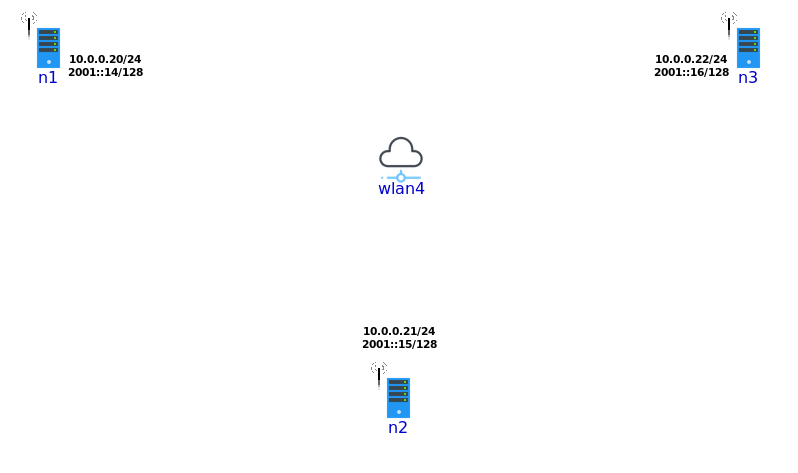

In this scenario, three nodes start off with no connection between them. `n1` and `n3` are each pre-loaded with 1,000 articles that are in the DB of the *moNNT.py Server* and in the store of the *dtnd*. Then the simulation runs through the following steps:

1. Wait 10 seconds
2. `n2` moves into proximity of `n1` -- after a short period both *dtnd* instances will discover eachother and exchange previously unknown bundles, which will then be pushed to the respective *moNNT.py* instance.
3. Wait 10 seconds
4. `n2` moves into proximity of `n3` -- analog to step 2.
5. Wait 10 seconds

In [18]:
reports_dir = "net-emu/eval/1k/multirun-results"
processes = ["python", "dtnd"]
pidstat_df = get_pidstat_df(reports_dir=reports_dir, nodes=nodes)

#### CPU utilization, memory usage, and storage writes

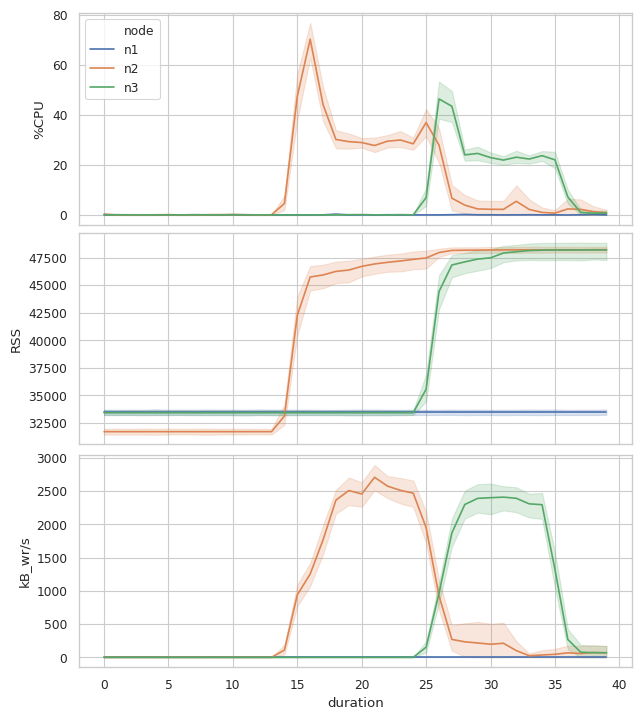

In [83]:
cols, rows = [1, 3]

fig, ax = plt.subplots(rows, cols, figsize=(16*cm, 3*6*cm), constrained_layout=True, sharex=True)
for i, g in enumerate(["%CPU", "RSS", "kB_wr/s"]):
    data = pidstat_df[pidstat_df["Command"].isin(processes)]
    sns.lineplot(data=data, x="duration", y=g, hue="node", style="Command", ax=ax[i])
    ax[i].get_legend().remove()

# edit legend to only display once and exclude process name "python"
global_handles, _ = fig.gca().get_legend_handles_labels()
_ = ax[0].legend(current_handles, ["node", "n1", "n2", "n3"], loc="upper left")

#### Network transfers

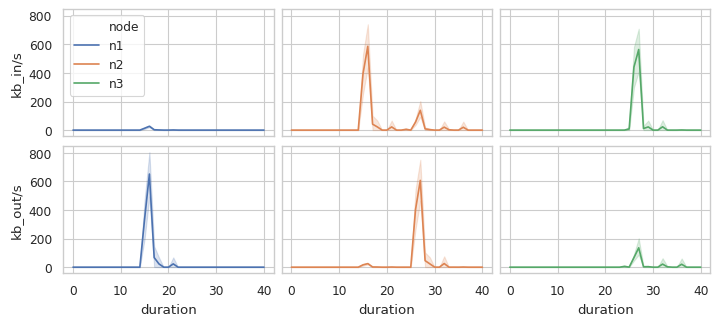

In [84]:
reports_dir = "net-emu/eval/1k/multirun-results"
net_df = get_network_df(reports_dir=reports_dir, nodes=nodes)
y_cols = ["kb_in/s", "kb_out/s"]  # , "bytes_total/s"]

fig, ax = plt.subplots(2, 3, figsize=(18*cm, 2*4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, y_col in enumerate(y_cols):
    for j, n in enumerate(nodes):
        sns.lineplot(
            data=net_df[(net_df["iface_name"] == "total") & (net_df["node"] == n)],
            x="duration", y=y_col, color=sns.color_palette()[j], ax=ax[i][j])

_ = ax[0][0].legend(current_handles, ["node", "n1", "n2", "n3"], loc="upper left")